# Logistic Regression

## Overview

A logistic regression is used when the outcome we are interested in is a categorical one. In this case, we are interested in whether or not a patient was readmitted within 30 days -- an outcome with two categories (yes or no). There are a few steps to take before running the regression, though.

## Preparing to Map Features
Before running a logistic regression, it is important to map categorical features into separate, binary variables for each of their categories (more information on that process soon). But first, we need to prepare a few variables for mapping. First, the number of lab procedures ranges from 1-132, but in some cases there are very few patients who had a given number of procedures. To keep a desirable ratio of new binary variables to actual observations, we'll first bin the number of procedures so that there are only 13 new variables, which will make machine-learning techniques more fruitful. 

There are also a few ID features (e.g., admission type ID) that are functionally categorical but have numeric values. We'll change their data types so that we can map those variables accordingly, too. 

In [57]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import *

import pandas as pd
import numpy as np
import matplotlib as plt
%matplotlib inline

In [3]:
#read in wrangled data set 
readmit = pd.read_csv('readmit_for_map.csv')
readmit.head()

,race,gender,age,admission_type_id,discharge_disposition_id,admission_source_id,days_in_hospital,num_lab_procedures,num_procedures,num_medications,...,glimepiride_pioglitazone,metformin_rosiglitazone,metformin_pioglitazone,change,diabetesMed,readmit30,num_visits,first_diag,second_diag,third_diag
0,Caucasian,Female,[50-60),2,1,1,8,77,6,33,...,No,No,No,Ch,Yes,1,2,circulatory,injury,digestive
1,Caucasian,Female,[50-60),3,1,1,2,49,1,11,...,No,No,No,No,No,0,1,musculoskeletal,other,diabetes
2,Caucasian,Female,[80-90),1,3,7,4,68,2,23,...,No,No,No,No,Yes,0,1,injury,respiratory,other
3,Caucasian,Female,[80-90),1,1,7,3,46,0,20,...,No,No,No,Ch,Yes,0,1,neoplasms,circulatory,circulatory
4,AfricanAmerican,Female,[30-40),1,1,7,5,49,0,5,...,No,No,No,No,Yes,0,1,genitourinary,neoplasms,diabetes


In [4]:
# bin mumber of lab procedures variable
 # write function
def bin_labs(col):
    if (col >= 1) & (col <= 10):
        return '[1-10]'
    if (col >= 11) & (col <= 20):
        return '[11-20]'
    if (col >= 21) & (col <= 30):
        return '[21-30]'
    if (col >= 31) & (col <= 40):
        return '[31-40]'
    if (col >= 41) & (col <= 50):
        return '[41-50]'
    if (col >= 51) & (col <= 60):
        return '[51-60]'
    if (col >= 61) & (col <= 70):
        return '[61-70]'
    if (col >= 71) & (col <= 80):
        return '[71-80]'
    if (col >= 81) & (col <= 90):
        return '[81-90]'
    if (col >= 91) & (col <= 100):
        return '[91-100]'
    if (col >= 101) & (col <= 110):
        return '[101-110]'
    if (col >= 111) & (col <= 120):
        return '[111-120]'
    else:
        return '[121-132]' 

In [5]:
 # apply function to relevant variable, check df
readmit['num_lab_procs'] = readmit.num_lab_procedures.apply(lambda col: bin_labs(col))
readmit.head()

,race,gender,age,admission_type_id,discharge_disposition_id,admission_source_id,days_in_hospital,num_lab_procedures,num_procedures,num_medications,...,metformin_rosiglitazone,metformin_pioglitazone,change,diabetesMed,readmit30,num_visits,first_diag,second_diag,third_diag,num_lab_procs
0,Caucasian,Female,[50-60),2,1,1,8,77,6,33,...,No,No,Ch,Yes,1,2,circulatory,injury,digestive,[71-80]
1,Caucasian,Female,[50-60),3,1,1,2,49,1,11,...,No,No,No,No,0,1,musculoskeletal,other,diabetes,[41-50]
2,Caucasian,Female,[80-90),1,3,7,4,68,2,23,...,No,No,No,Yes,0,1,injury,respiratory,other,[61-70]
3,Caucasian,Female,[80-90),1,1,7,3,46,0,20,...,No,No,Ch,Yes,0,1,neoplasms,circulatory,circulatory,[41-50]
4,AfricanAmerican,Female,[30-40),1,1,7,5,49,0,5,...,No,No,No,Yes,0,1,genitourinary,neoplasms,diabetes,[41-50]


In [6]:
 # drop old lab-procedures variable
readmit_procs = readmit.drop(['num_lab_procedures'], axis = 1)

In [7]:
# change categorical variables from numeric to object where necessary
cols = readmit_procs[['admission_type_id', 'discharge_disposition_id', 'admission_source_id']] 
readmit_procs[['admission_type_id', 'discharge_disposition_id', 'admission_source_id']] = cols.astype(object)

## Mapping the Features

Before performing logistic regression, we need to map variables with text values to series of binary features. For example, suppose there are three admission types: A, B, and C. In the original admission-type column in the data set, each patient encounter would have A, B, or C. But machine-learning algorithms read binaries (and numerical categories, where appropriate) instead of letters and words. The encoding process creates two new columns: A and B. A patient encounter will have 1 in A and 0 in B to indicate admission type A. Converse encoding indicates type B, and a 0 in both columns indicates type C. This process is called one-hot encoding, and it will be helpful in other types of analysis like tree-based analysis as well. 

In [8]:
# check variable types -- only integer and object
print(readmit_procs.dtypes.unique())

[dtype('O') dtype('int64')]


In [9]:
# one-hot encoding for each object-column value
 # columns setting converts object and category dtypes; dropfirst creates n-1 dummies for n categories of a variable
one_hot = pd.get_dummies(readmit_procs, columns = None, drop_first = True) 
one_hot.head()

,days_in_hospital,num_procedures,num_medications,number_outpatient,number_emergency,number_inpatient,number_diagnoses,readmit30,num_visits,race_Asian,...,num_lab_procs_[111-120],num_lab_procs_[121-132],num_lab_procs_[21-30],num_lab_procs_[31-40],num_lab_procs_[41-50],num_lab_procs_[51-60],num_lab_procs_[61-70],num_lab_procs_[71-80],num_lab_procs_[81-90],num_lab_procs_[91-100]
0,8,6,33,0,0,0,8,1,2,0,...,0,0,0,0,0,0,0,1,0,0
1,2,1,11,0,0,0,3,0,1,0,...,0,0,0,0,1,0,0,0,0,0
2,4,2,23,0,0,0,9,0,1,0,...,0,0,0,0,0,0,1,0,0,0
3,3,0,20,0,0,0,9,0,1,0,...,0,0,0,0,1,0,0,0,0,0
4,5,0,5,0,0,0,3,0,1,0,...,0,0,0,0,1,0,0,0,0,0


In [ ]:
# write one-hot-encoded dataframe to csv for use in other analyses
one_hot.to_csv('diabetes_readmission_onehot.csv')

## Running the Logistic Regression

Now we are ready to perform the regression. There a few things to note as this process happens. The first step is to split the data into a training and a test set. The training data is used to build the logistic model; it is the data that the model "learns" on. Once the model is constructed from the training data, we'll run it on the test data to make sure it generalizes -- or works on other data sets -- well. The test data was set aside before building the model precisely for this purpose. 

In [10]:
# capture independent variables in list
features = list(one_hot)
features.remove('readmit30')

In [29]:
# split the data into a training and test set
Xtrain, Xtest, Ytrain, Ytest = train_test_split(one_hot[features].values, 
                                              (one_hot.readmit30 == 1).values, test_size = .2, random_state = 7)

Now that the data set is split, we can set up the regression and run it. There are a few important things happening in this process. First is the creation of a grid of possible values for C, which is a tuning parameter used when data cannot be separated into two categories with a clean, straight line in the x-y plane. When a best attempt at such a line is drawn, some observations that belong to one category might still lie on the "wrong" side of the separating line. To account for this dynamic, we introduce a tuning parameter into the math of logistic regression. This step ideally creates a value of C that is neither too high nor too low. The former could create a model that is too biased toward the training data to be generalizable, and the latter could create a model with too much variance to have much predictive value (kind of like a jack of all trades being a master of none). 

The second tool at hand is the GridSearchCV function. The grid search allows us to perform an exhaustive search for the best C in just one line of code. The process also uses cross validation and an l2 penalty, which both help manage variance and in turn keep the model from becoming too general to the point that its predictive value is weakened.

In [27]:
# create grid, run grid search w/ logistic regression, find best C and its accuracy score

C_grid = {'C': [0.001, 0.1, 1, 10, 100]} #dictionary w/ C as key and possible values
clf_grid = GridSearchCV(LogisticRegression(penalty='l2'), C_grid, cv = 5, scoring = 'accuracy') #specs of grid search
clf_grid.fit(Xtrain, Ytrain) #fit model on training data

print(clf_grid.best_params_, clf_grid.best_score_) #output best C and best accuracy score

#clf_grid.cv_results_ #more thorough analysis of grid search results by C

{'C': 0.001} 0.907601683029


In [30]:
# check performance on test set
clf_grid_test = LogisticRegression(C = clf_grid.best_params_['C'])
clf_grid_test.fit(Xtest, Ytest)
accuracy_score(clf_grid_test.predict(Xtest), Ytest)

0.90866930959682846

The chosen model (with the best C and accuracy score) has an accuracy score of about .908, which means that 90.8% of the model's predictions made about readmission within 30 days were correct. This number seems pretty good, and while accuracy can be an okay starting point to assess model performance, it isn't necessarily the best one for this case. Accuracy score is usually better when the number of observations is equal for each category within a feature, so let's look at another performance metric -- the area under an ROC curve -- next. 

An ROC curve reflects how well a model differentiates positive (readmission within 30 days, in our case) and negative outcomes. A model making all predictions correctly has an area of 1. A model that performs no better than random guessing has an area of 0.5. As we'll see in a moment, the curve itself plots the true positive rate against the false positive rate to help observers gauge performance.

In [94]:
# logistic regression with area under ROC curve as metric
C_grid = {'C': [0.001, 0.1, 1, 10, 100]} 
clf_grid_ROC = GridSearchCV(LogisticRegression(penalty='l2'), C_grid, cv = 5, scoring = 'roc_auc')
clf_grid_ROC.fit(Xtrain, Ytrain) 
print(clf_grid_ROC.best_params_, clf_grid_ROC.best_score_) 

{'C': 0.1} 0.755954347632


In [97]:
# check ROC performance on test set
clf_grid_ROC_test = LogisticRegression(C = clf_grid_ROC.best_params_['C'])
clf_grid_ROC_test.fit(Xtest, Ytest)

probs = clf_grid_ROC_test.predict_proba(Xtest)
preds = probs[:,1]
roc_auc_score(Ytest, preds)

0.78286555218587695

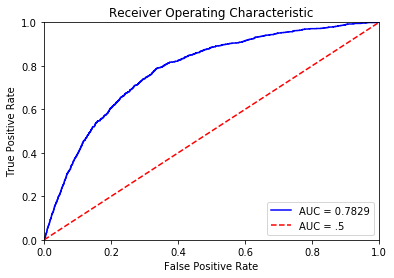

In [98]:
# plot ROC curve

fpr, tpr, threshold = roc_curve(Ytest, preds) #find true- and false-positive rates for relevant decision thresholds
roc_auc = auc(fpr, tpr) #compute area under ROC curve using trapezoidal rule (not a binary classification here)

plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'blue', label = 'AUC = %0.4f' % roc_auc) #create line with AUC value for test data
plt.plot([0, 1], [0, 1],'r--', label = 'AUC = .5') #create line with AUC=.5 for comparison
plt.legend(loc = 'lower right')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show() 

A (theoretically) perfect ROC curve comprises a vertical line along the y-axis joined with a horizontal line at y = 1. The closer our curve is to that ideal one, the better it is. So our curve is looking pretty good. Another line of comparison is the dotted red line, which represents at 50% success rate for binary predictions. If our model's line falls to this point, it is no better than randomly guessing would be. 

Finally, some users prefer to use another metric called precision-recall instead of ROC curves. Precision-recall analysis reports various percentages for how well a model does at classifying observations accurately for an outcome. I'll talk about this more once we produce the numbers in a classification report below. 

In [100]:
# classification report

predicted = clf_grid_ROC_test.predict(Xtest) #capture predictions for Y based on data in X
report = classification_report(Ytest, predicted) #classify actual Y values in test data vs. those predicted in X
print(report)

             precision    recall  f1-score   support

      False       0.91      0.99      0.95     12161
       True       0.34      0.03      0.05      1208

avg / total       0.86      0.91      0.87     13369



Precision reflects the percentage of correct classifications among all observations put into one class (e.g., not readmitted within 30 days) by the model. 